<span style="color:orange">

# Home Appliances Energy Prediction using Machine Learning

# Project Overview

### Description

Experimental data used to create regression models of appliances energy use in a low energy building.

## Data Source
- **UCI Machine Repository**
- **Luis Candanedo, University of Mons (UMONS)**
- **Contact:** luismiguel.candanedoibarra '@' umons.ac.be
- **Link:** [Appliances energy prediction dataset](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction)


### Dataset Information

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non-predictive attributes (parameters).

### Attribute Information

1. **date:** year-month-day hour:minute:second 
2. **Appliances:** energy use in Wh (watt-hour)
3. **lights:** energy use of light fixtures in the house in Wh (watt-hour)
4. **T1:** Temperature in kitchen area, in Celsius
5. **RH_1:** Humidity in kitchen area, in %
6. **T2:** Temperature in living room area, in Celsius
7. **RH_2:** Humidity in living room area, in %
8. **T3:** Temperature in laundry room area
9. **RH_3:** Humidity in laundry room area, in %
10. **T4:** Temperature in office room, in Celsius
11. **RH_4:** Humidity in office room, in %
12. **T5:** Temperature in bathroom, in Celsius
13. **RH_5:** Humidity in bathroom, in %
14. **T6:** Temperature outside the building (north side), in Celsius
15. **RH_6:** Humidity outside the building (north side), in %
16. **T7:** Temperature in ironing room , in Celsius
17. **RH_7:** Humidity in ironing room, in %
18. **T8:** Temperature in teenager room 2, in Celsius
19. **RH_8:** Humidity in teenager room 2, in %
20. **T9:** Temperature in parents room, in Celsius
21. **RH_9:** Humidity in parents room, in %
22. **To:** Temperature outside (from Chievres weather station), in Celsius
23. **Pressure:** (from Chievres weather station), in mm Hg
24. **RH_out:** Humidity outside (from Chievres weather station), in %
25. **Wind speed:** (from Chievres weather station), in m/s
26. **Visibility:** (from Chievres weather station), in km
27. **Tdewpoint:** (from Chievres weather station), °C
28. **rv1:** Random variable 1, nondimensional
29. **rv2:** Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis, rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of weather data.


## Importing the Libraries

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import opendatasets as od

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, roc_curve, roc_auc_score, mean_squared_error, accuracy_score
from scipy import stats
from scipy.stats import zscore
from datetime import datetime 
import dateutil
import math, sys, time

## 1. Data Preparation

In [2]:
od.download('https://www.kaggle.com/datasets/loveall/appliances-energy-prediction')

Skipping, found downloaded files in ".\appliances-energy-prediction" (use force=True to force download)


In [3]:
os.listdir('appliances-energy-prediction')

['KAG_energydata_complete.csv']

## 2. Import Dataset & Basic operations

In [4]:
energy_df = pd.read_csv('appliances-energy-prediction/KAG_energydata_complete.csv')
energy_df

date  Appliances  lights         T1       RH_1  \
0      2016-01-11 17:00:00          60      30  19.890000  47.596667   
1      2016-01-11 17:10:00          60      30  19.890000  46.693333   
2      2016-01-11 17:20:00          50      30  19.890000  46.300000   
3      2016-01-11 17:30:00          50      40  19.890000  46.066667   
4      2016-01-11 17:40:00          60      40  19.890000  46.333333   
...                    ...         ...     ...        ...        ...   
19730  2016-05-27 17:20:00         100       0  25.566667  46.560000   
19731  2016-05-27 17:30:00          90       0  25.500000  46.500000   
19732  2016-05-27 17:40:00         270      10  25.500000  46.596667   
19733  2016-05-27 17:50:00         420      10  25.500000  46.990000   
19734  2016-05-27 18:00:00         430      10  25.500000  46.600000   

              T2       RH_2         T3       RH_3         T4  ...         T9  \
0      19.200000  44.790000  19.790000  44.730000  19.000000  ...  17.033333   
1      19.200000  44.722500  19.790000  44.790000  19.000000  ...  17.066667   
2      19.200000  44.626667  19.790000  44.933333  18.926667  ...  17.000000   
3      19.200000  44.590000  19.790000  45.000000  18.890000  ...  17.000000   
4      19.200000  44.530000  19.790000  45.000000  18.890000  ...  17.000000   
...          ...        ...        ...        ...        ...  ...        ...   
19730  25.890000  42.025714  27.200000  41.163333  24.700000  ...  23.200000   
19731  25.754000  42.080000  27.133333  41.223333  24.700000  ...  23.200000   
19732  25.628571  42.768571  27.050000  41.690000  24.700000  ...  23.200000   
19733  25.414000  43.036000  26.890000  41.290000  24.700000  ...  23.200000   
19734  25.264286  42.971429  26.823333  41.156667  24.700000  ...  23.200000   

          RH_9      T_out  Press_mm_hg     RH_out  Windspeed  Visibility  \
0      45.5300   6.600000        733.5  92.000000   7.000000   63.000000   
1      45.5600   6.483333        733.6  92.000000   6.666667   59.166667   
2      45.5000   6.366667        733.7  92.000000   6.333333   55.333333   
3      45.4000   6.250000        733.8  92.000000   6.000000   51.500000   
4      45.4000   6.133333        733.9  92.000000   5.666667   47.666667   
...        ...        ...          ...        ...        ...         ...   
19730  46.7900  22.733333        755.2  55.666667   3.333333   23.666667   
19731  46.7900  22.600000        755.2  56.000000   3.500000   24.500000   
19732  46.7900  22.466667        755.2  56.333333   3.666667   25.333333   
19733  46.8175  22.333333        755.2  56.666667   3.833333   26.166667   
19734  46.8450  22.200000        755.2  57.000000   4.000000   27.000000   

       Tdewpoint        rv1        rv2  
0       5.300000  13.275433  13.275433  
1       5.200000  18.606195  18.606195  
2       5.100000  28.642668  28.642668  
3       5.000000  45.410389  45.410389  
4       4.900000  10.084097  10.084097  
...          ...        ...        ...  
19730  13.333333  43.096812  43.096812  
19731  13.300000  49.282940  49.282940  
19732  13.266667  29.199117  29.199117  
19733  13.233333   6.322784   6.322784  
19734  13.200000  34.118851  34.118851  

[19735 rows x 29 columns]

In [5]:
# Visualise data info
energy_df.shape

(19735, 29)

In [6]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [7]:
# Check for null value
energy_df.isna().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [8]:
energy_df.describe().T

count        mean         std         min         25%  \
Appliances   19735.0   97.694958  102.524891   10.000000   50.000000   
lights       19735.0    3.801875    7.935988    0.000000    0.000000   
T1           19735.0   21.686571    1.606066   16.790000   20.760000   
RH_1         19735.0   40.259739    3.979299   27.023333   37.333333   
T2           19735.0   20.341219    2.192974   16.100000   18.790000   
RH_2         19735.0   40.420420    4.069813   20.463333   37.900000   
T3           19735.0   22.267611    2.006111   17.200000   20.790000   
RH_3         19735.0   39.242500    3.254576   28.766667   36.900000   
T4           19735.0   20.855335    2.042884   15.100000   19.530000   
RH_4         19735.0   39.026904    4.341321   27.660000   35.530000   
T5           19735.0   19.592106    1.844623   15.330000   18.277500   
RH_5         19735.0   50.949283    9.022034   29.815000   45.400000   
T6           19735.0    7.910939    6.090347   -6.065000    3.626667   
RH_6         19735.0   54.609083   31.149806    1.000000   30.025000   
T7           19735.0   20.267106    2.109993   15.390000   18.700000   
RH_7         19735.0   35.388200    5.114208   23.200000   31.500000   
T8           19735.0   22.029107    1.956162   16.306667   20.790000   
RH_8         19735.0   42.936165    5.224361   29.600000   39.066667   
T9           19735.0   19.485828    2.014712   14.890000   18.000000   
RH_9         19735.0   41.552401    4.151497   29.166667   38.500000   
T_out        19735.0    7.411665    5.317409   -5.000000    3.666667   
Press_mm_hg  19735.0  755.522602    7.399441  729.300000  750.933333   
RH_out       19735.0   79.750418   14.901088   24.000000   70.333333   
Windspeed    19735.0    4.039752    2.451221    0.000000    2.000000   
Visibility   19735.0   38.330834   11.794719    1.000000   29.000000   
Tdewpoint    19735.0    3.760707    4.194648   -6.600000    0.900000   
rv1          19735.0   24.988033   14.496634    0.005322   12.497889   
rv2          19735.0   24.988033   14.496634    0.005322   12.497889   

                    50%         75%          max  
Appliances    60.000000  100.000000  1080.000000  
lights         0.000000    0.000000    70.000000  
T1            21.600000   22.600000    26.260000  
RH_1          39.656667   43.066667    63.360000  
T2            20.000000   21.500000    29.856667  
RH_2          40.500000   43.260000    56.026667  
T3            22.100000   23.290000    29.236000  
RH_3          38.530000   41.760000    50.163333  
T4            20.666667   22.100000    26.200000  
RH_4          38.400000   42.156667    51.090000  
T5            19.390000   20.619643    25.795000  
RH_5          49.090000   53.663333    96.321667  
T6             7.300000   11.256000    28.290000  
RH_6          55.290000   83.226667    99.900000  
T7            20.033333   21.600000    26.000000  
RH_7          34.863333   39.000000    51.400000  
T8            22.100000   23.390000    27.230000  
RH_8          42.375000   46.536000    58.780000  
T9            19.390000   20.600000    24.500000  
RH_9          40.900000   44.338095    53.326667  
T_out          6.916667   10.408333    26.100000  
Press_mm_hg  756.100000  760.933333   772.300000  
RH_out        83.666667   91.666667   100.000000  
Windspeed      3.666667    5.500000    14.000000  
Visibility    40.000000   40.000000    66.000000  
Tdewpoint      3.433333    6.566667    15.500000  
rv1           24.897653   37.583769    49.996530  
rv2           24.897653   37.583769    49.996530

In [9]:
energy_df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [10]:
#Data load 
a=["date","Appliances","T1","RH_1","T2","RH_2","T3",
   "RH_3","T4","RH_4","T5","RH_5","T6","RH_6","T7",
   "RH_7","T8","RH_8","T9","RH_9","T_out","RH_out",
   "Windspeed","Visibility",'Press_mm_hg', 'Tdewpoint', 'lights']

In [11]:
energy_df = energy_df[a]
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 non-null  float64
 19  RH_9

In [12]:
energy_df.shape

(19735, 27)

In [13]:
energy_df.head()

date  Appliances     T1       RH_1    T2       RH_2     T3  \
0  2016-01-11 17:00:00          60  19.89  47.596667  19.2  44.790000  19.79   
1  2016-01-11 17:10:00          60  19.89  46.693333  19.2  44.722500  19.79   
2  2016-01-11 17:20:00          50  19.89  46.300000  19.2  44.626667  19.79   
3  2016-01-11 17:30:00          50  19.89  46.066667  19.2  44.590000  19.79   
4  2016-01-11 17:40:00          60  19.89  46.333333  19.2  44.530000  19.79   

        RH_3         T4       RH_4  ...       RH_8         T9   RH_9  \
0  44.730000  19.000000  45.566667  ...  48.900000  17.033333  45.53   
1  44.790000  19.000000  45.992500  ...  48.863333  17.066667  45.56   
2  44.933333  18.926667  45.890000  ...  48.730000  17.000000  45.50   
3  45.000000  18.890000  45.723333  ...  48.590000  17.000000  45.40   
4  45.000000  18.890000  45.530000  ...  48.590000  17.000000  45.40   

      T_out  RH_out  Windspeed  Visibility  Press_mm_hg  Tdewpoint  lights  
0  6.600000    92.0   7.000000   63.000000        733.5        5.3      30  
1  6.483333    92.0   6.666667   59.166667        733.6        5.2      30  
2  6.366667    92.0   6.333333   55.333333        733.7        5.1      30  
3  6.250000    92.0   6.000000   51.500000        733.8        5.0      40  
4  6.133333    92.0   5.666667   47.666667        733.9        4.9      40  

[5 rows x 27 columns]

## 3. Extracting components from date object

In [14]:
# Convert 'date' column to datetime format without modifying original DataFrame
energy_df['date'] = pd.to_datetime(energy_df['date'])

energy_df['exact_date'] = energy_df['date'].dt.date  # Extract date part
energy_df['hours'] = energy_df['date'].dt.hour  # Extract hour
energy_df['seconds'] = energy_df['date'].dt.minute * 60  # Extract minute and convert to seconds
energy_df['days'] = energy_df['date'].dt.day_name()  # Extract day name
energy_df['days_num'] = energy_df['date'].dt.dayofweek  # Extract day of the week as numeric

# Convert 'date' column back to 'object' type
energy_df['date'] = energy_df['date'].astype(object)

C:\Users\HP\AppData\Local\Temp\ipykernel_15392\4213298913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df['date'] = pd.to_datetime(energy_df['date'])
C:\Users\HP\AppData\Local\Temp\ipykernel_15392\4213298913.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df['exact_date'] = energy_df['date'].dt.date  # Extract date part


In [15]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 non-null  float64
 19  RH_9

In [16]:
energy_df.describe()

Appliances            T1          RH_1            T2          RH_2  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      97.694958     21.686571     40.259739     20.341219     40.420420   
std      102.524891      1.606066      3.979299      2.192974      4.069813   
min       10.000000     16.790000     27.023333     16.100000     20.463333   
25%       50.000000     20.760000     37.333333     18.790000     37.900000   
50%       60.000000     21.600000     39.656667     20.000000     40.500000   
75%      100.000000     22.600000     43.066667     21.500000     43.260000   
max     1080.000000     26.260000     63.360000     29.856667     56.026667   

                 T3          RH_3            T4          RH_4            T5  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      22.267611     39.242500     20.855335     39.026904     19.592106   
std        2.006111      3.254576      2.042884      4.341321      1.844623   
min       17.200000     28.766667     15.100000     27.660000     15.330000   
25%       20.790000     36.900000     19.530000     35.530000     18.277500   
50%       22.100000     38.530000     20.666667     38.400000     19.390000   
75%       23.290000     41.760000     22.100000     42.156667     20.619643   
max       29.236000     50.163333     26.200000     51.090000     25.795000   

       ...         T_out        RH_out     Windspeed    Visibility  \
count  ...  19735.000000  19735.000000  19735.000000  19735.000000   
mean   ...      7.411665     79.750418      4.039752     38.330834   
std    ...      5.317409     14.901088      2.451221     11.794719   
min    ...     -5.000000     24.000000      0.000000      1.000000   
25%    ...      3.666667     70.333333      2.000000     29.000000   
50%    ...      6.916667     83.666667      3.666667     40.000000   
75%    ...     10.408333     91.666667      5.500000     40.000000   
max    ...     26.100000    100.000000     14.000000     66.000000   

        Press_mm_hg     Tdewpoint        lights         hours       seconds  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean     755.522602      3.760707      3.801875     11.502002   1499.923993   
std        7.399441      4.194648      7.935988      6.921953   1024.750707   
min      729.300000     -6.600000      0.000000      0.000000      0.000000   
25%      750.933333      0.900000      0.000000      6.000000    600.000000   
50%      756.100000      3.433333      0.000000     12.000000   1200.000000   
75%      760.933333      6.566667      0.000000     17.000000   2400.000000   
max      772.300000     15.500000     70.000000     23.000000   3000.000000   

           days_num  
count  19735.000000  
mean       2.977249  
std        1.985617  
min        0.000000  
25%        1.000000  
50%        3.000000  
75%        5.000000  
max        6.000000  

[8 rows x 29 columns]

## 4. Visualizing Per day consumption

Seasonality this is used to track seasonality. but we have only 4.25 months data so there were no traces of seasonality

The traces shows that there is varaiation of electric usage on granular terms (like days)

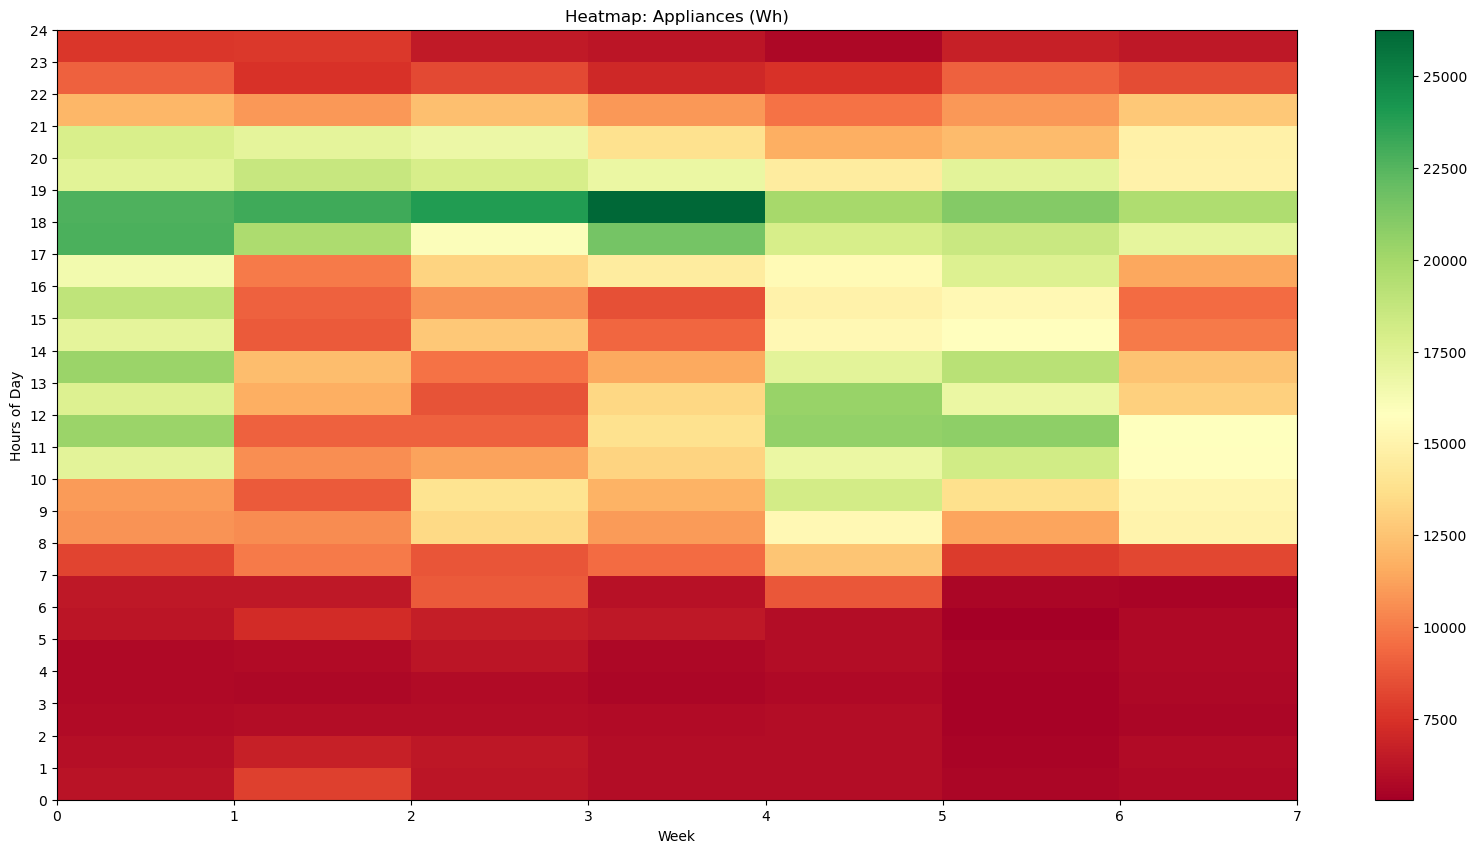

In [17]:
# Data Preparation
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
arranged_day = pd.Categorical(energy_df["days"], categories=days, ordered=True)
day_series = pd.Series(arranged_day)

# Creating Pivot Table
table = pd.pivot_table(energy_df,
                       index=["hours"],
                       values="Appliances",
                       columns=day_series,
                       aggfunc=[np.sum],
                       fill_value=0)

# Plotting Heatmap
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Heatmap: Appliances (Wh)')

heatmap = ax.pcolor(table, cmap='RdYlGn')  # Choose a colormap if needed

# Setting Labels and Ticks
ax.set_xlabel("Week Days")
ax.set_ylabel("Hours")

plt.colorbar(heatmap)
ax.set_xticks(range(len(table.columns)+1))
ax.set_yticks(range(len(table.index)+1))

# Displaying the Plot
plt.xlabel("Week")
plt.ylabel("Hours of Day")
plt.show()


## 5. Plotting

This plot shows that there is no such coorelation between energy conuption on weekdays vs off days

<Axes: >

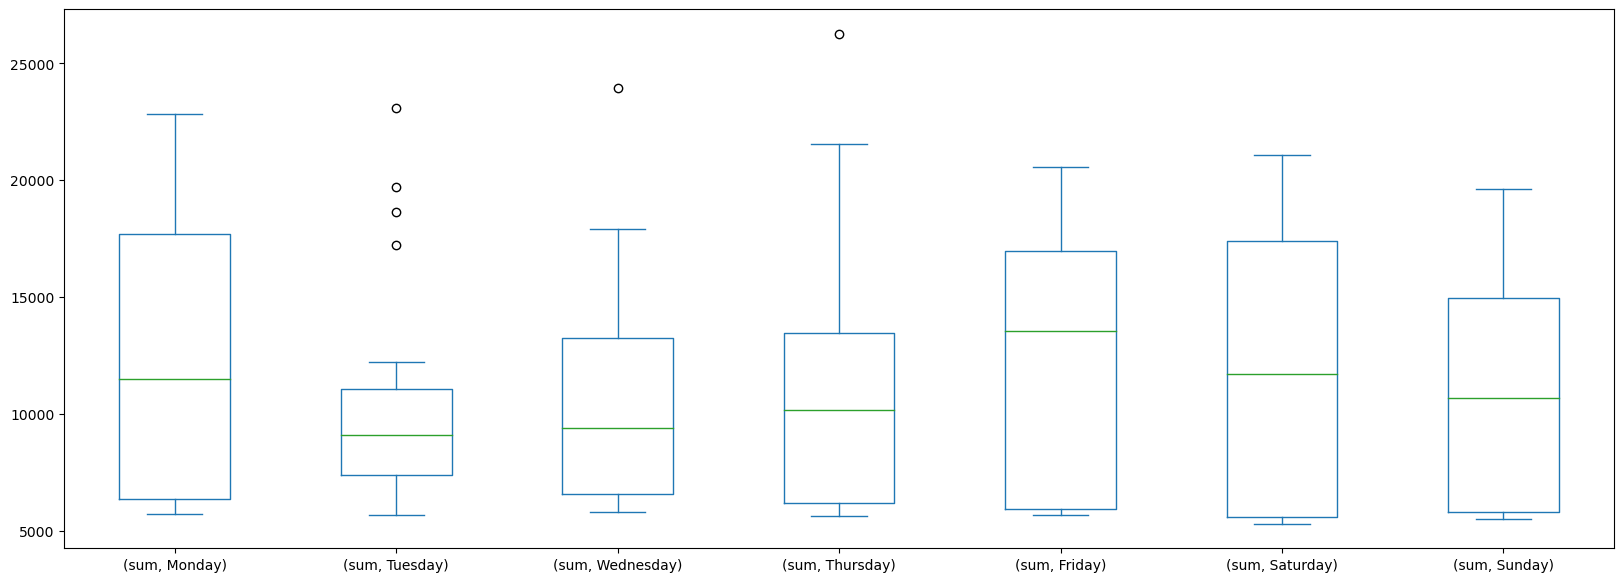

In [18]:
table.plot.box(figsize=(20, 7))

In [19]:
energy_df.head()

date  Appliances     T1       RH_1    T2       RH_2     T3  \
0  2016-01-11 17:00:00          60  19.89  47.596667  19.2  44.790000  19.79   
1  2016-01-11 17:10:00          60  19.89  46.693333  19.2  44.722500  19.79   
2  2016-01-11 17:20:00          50  19.89  46.300000  19.2  44.626667  19.79   
3  2016-01-11 17:30:00          50  19.89  46.066667  19.2  44.590000  19.79   
4  2016-01-11 17:40:00          60  19.89  46.333333  19.2  44.530000  19.79   

        RH_3         T4       RH_4  ...  Windspeed  Visibility  Press_mm_hg  \
0  44.730000  19.000000  45.566667  ...   7.000000   63.000000        733.5   
1  44.790000  19.000000  45.992500  ...   6.666667   59.166667        733.6   
2  44.933333  18.926667  45.890000  ...   6.333333   55.333333        733.7   
3  45.000000  18.890000  45.723333  ...   6.000000   51.500000        733.8   
4  45.000000  18.890000  45.530000  ...   5.666667   47.666667        733.9   

   Tdewpoint  lights  exact_date  hours  seconds    days  days_num  
0        5.3      30  2016-01-11     17        0  Monday         0  
1        5.2      30  2016-01-11     17      600  Monday         0  
2        5.1      30  2016-01-11     17     1200  Monday         0  
3        5.0      40  2016-01-11     17     1800  Monday         0  
4        4.9      40  2016-01-11     17     2400  Monday         0  

[5 rows x 32 columns]

In [20]:
table=energy_df[["Appliances",'lights', 'T1', 'RH_1',"Press_mm_hg",
          "RH_out","Windspeed","Visibility","Tdewpoint",'hours',
          'days_num']]

D:\msdownld.tmp\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


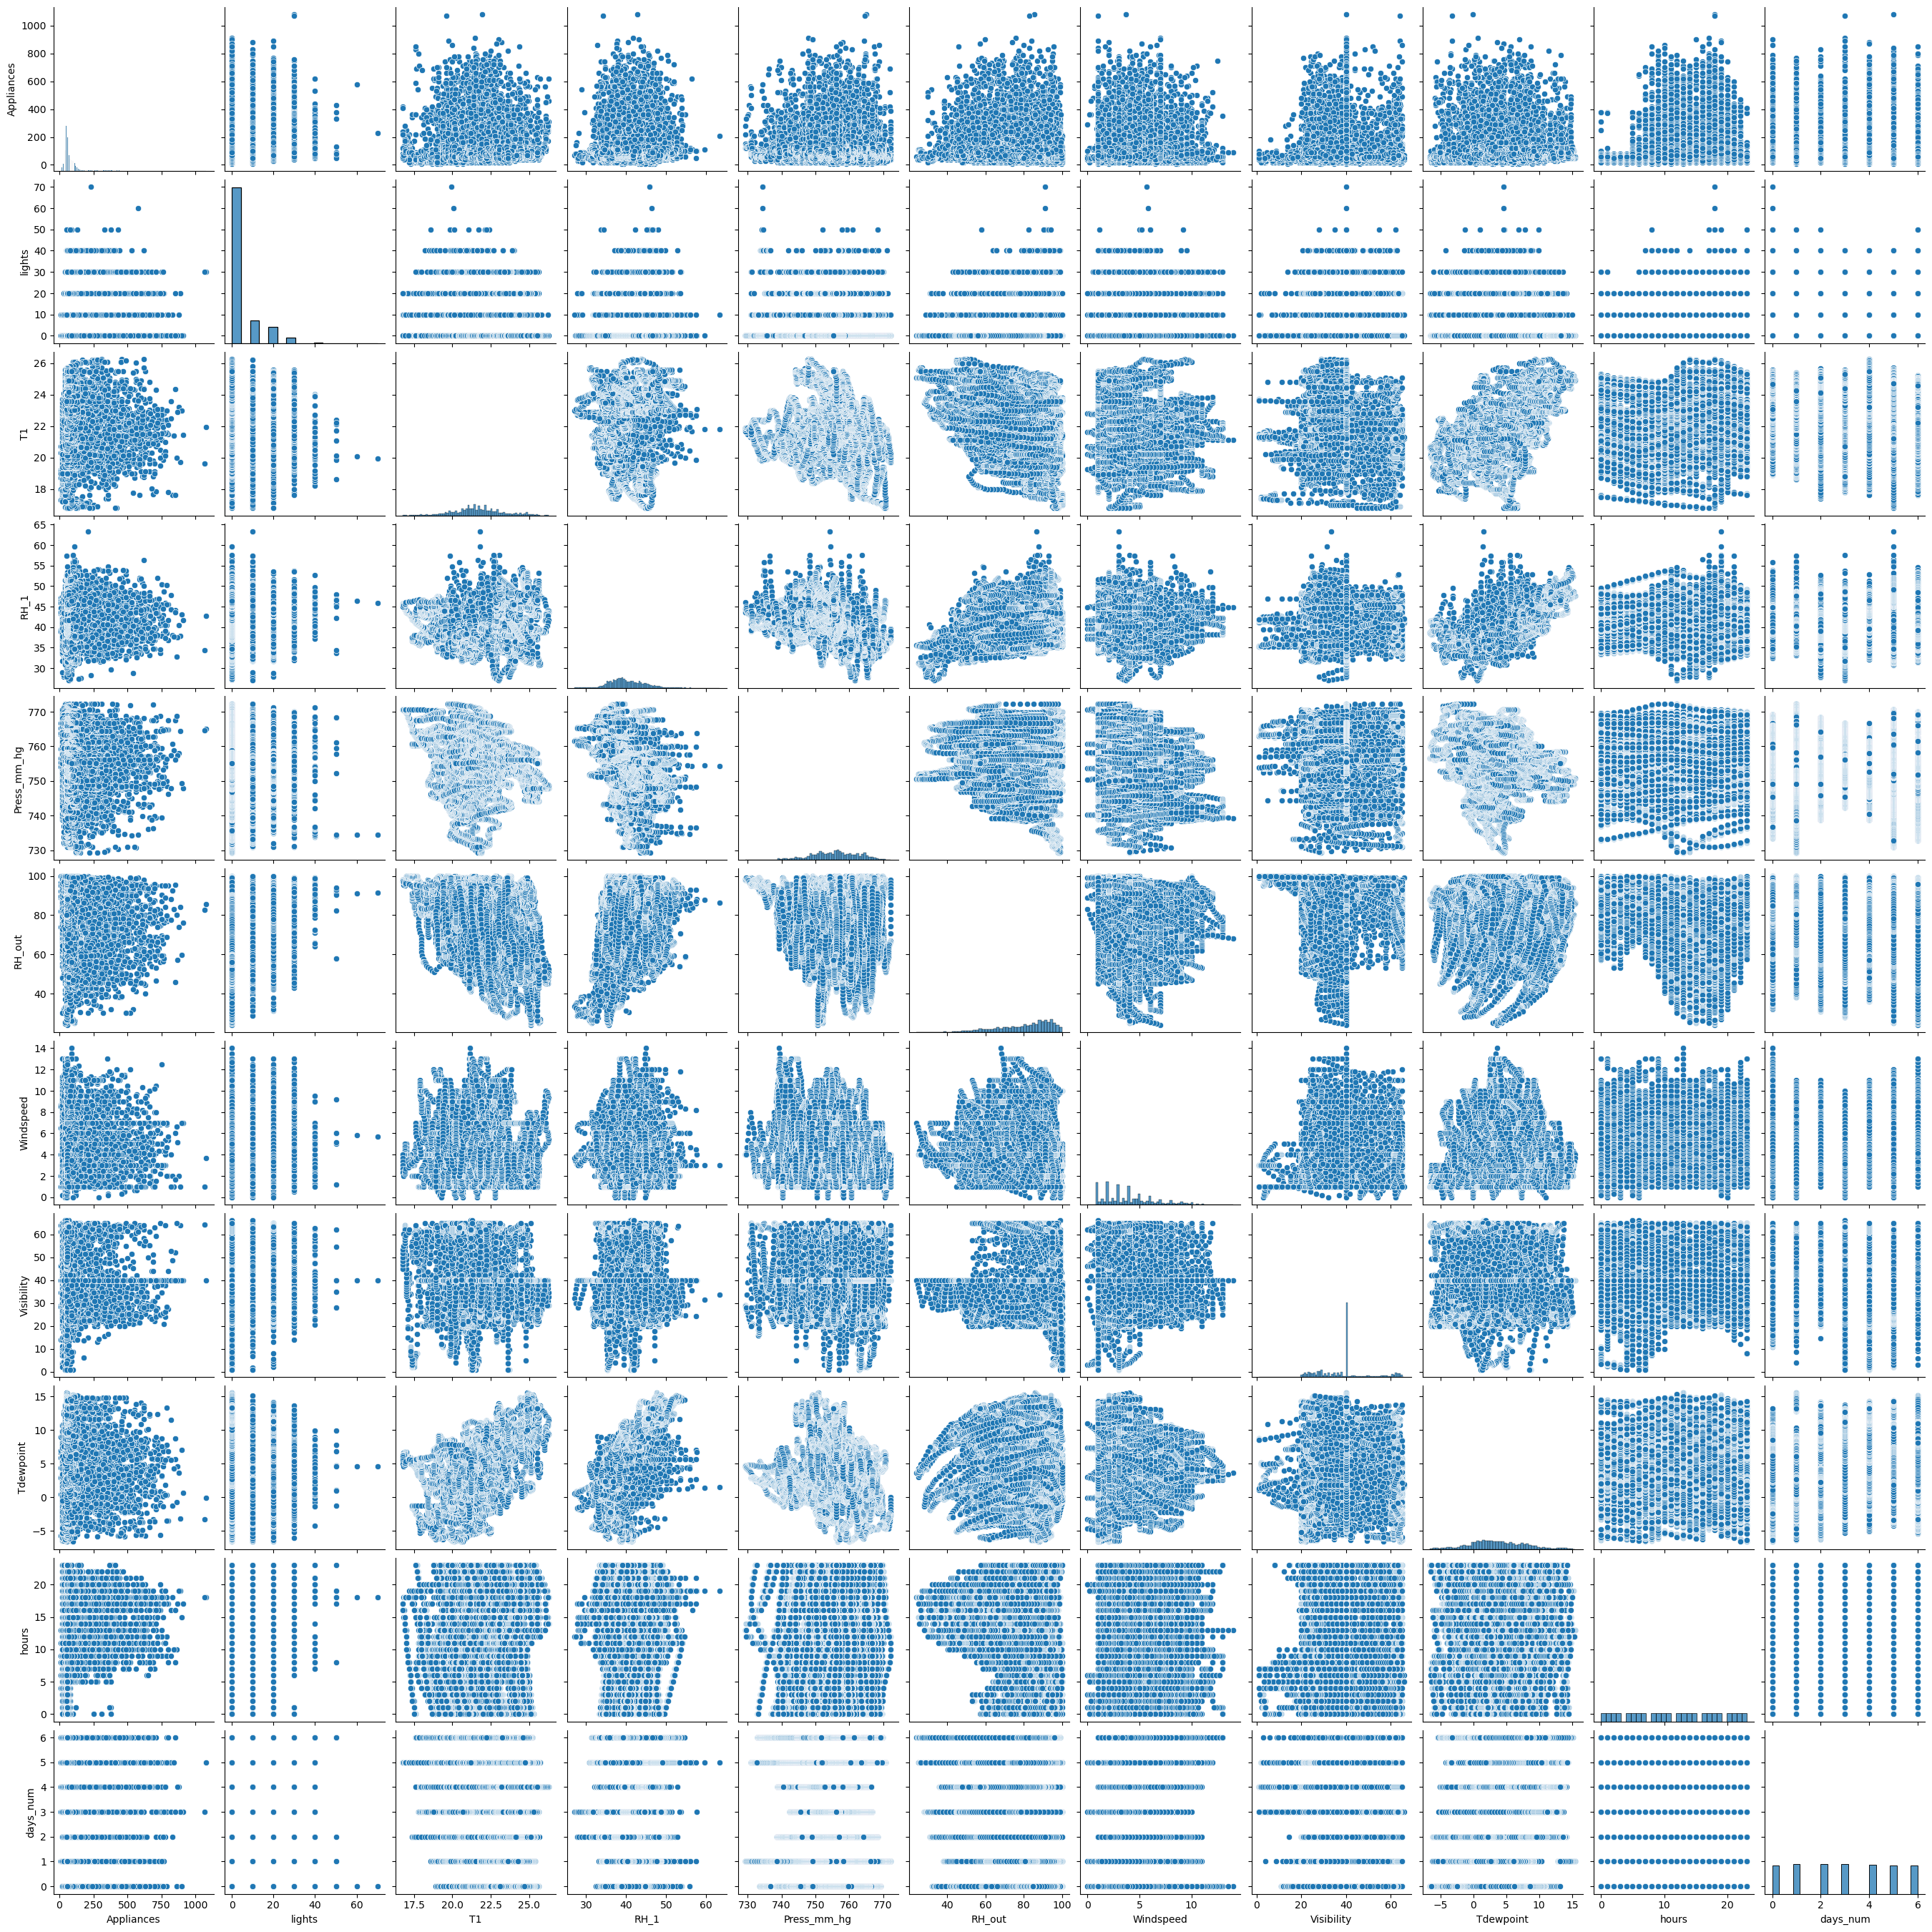

In [21]:
# Create a Pairplot
sns.pairplot(table)

In [22]:
df = energy_df
df.isna().sum()

date           0
Appliances     0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
RH_out         0
Windspeed      0
Visibility     0
Press_mm_hg    0
Tdewpoint      0
lights         0
exact_date     0
hours          0
seconds        0
days           0
days_num       0
dtype: int64

## 6. Outlier Removal

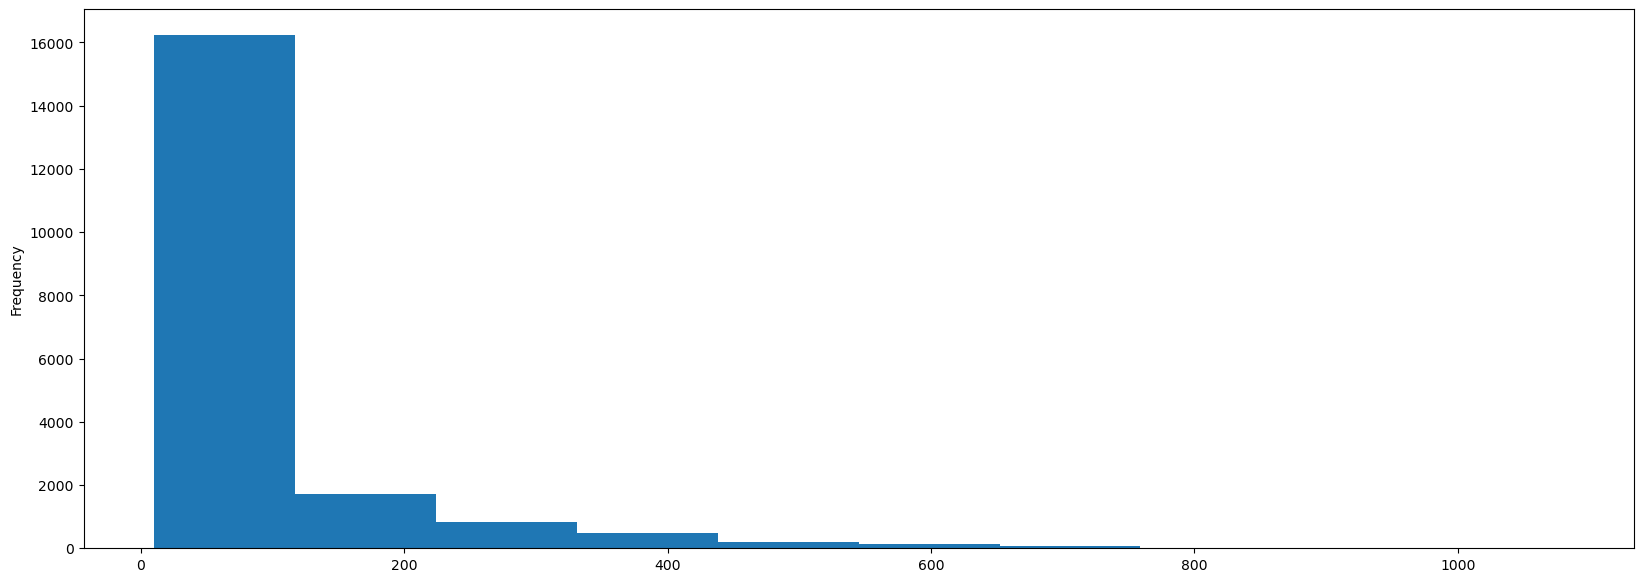

In [23]:
df['Appliances'].plot(kind="hist",figsize=(20, 7))
plt.show()

In [24]:
X = df[['Appliances']]
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
print("Outlier threshold of Appliances :",IQR)

outlier_df = X.describe()
outlier_set = set()
for column in outlier_df.columns:
    Q1 = outlier_df[column]['25%']
    Q3 = outlier_df[column]['75%']
    IQR = Q3 - Q1
    outlier_df = ((X[column] < (Q1 - 1.5 * IQR)) | (X[column] > (Q3 + 1.5 * IQR)))
    outlier_set.update(set(outlier_df[outlier_df==True].index))
    
df.drop(outlier_set, inplace=True, axis=0)    

Outlier threshold of Appliances : Appliances    50.0
dtype: float64


In [25]:
#examine the dataset
df.describe()

Appliances            T1          RH_1            T2          RH_2  \
count  17597.000000  17597.000000  17597.000000  17597.000000  17597.000000   
mean      67.209752     21.687492     40.141387     20.289424     40.472614   
std       28.480499      1.603825      3.927986      2.168958      4.061565   
min       10.000000     16.790000     27.023333     16.100000     20.463333   
25%       50.000000     20.760000     37.233333     18.790000     37.933333   
50%       60.000000     21.600000     39.530000     19.926667     40.560000   
75%       80.000000     22.600000     42.860000     21.463333     43.326667   
max      170.000000     26.200000     59.633333     29.856667     56.026667   

                 T3          RH_3            T4          RH_4            T5  \
count  17597.000000  17597.000000  17597.000000  17597.000000  17597.000000   
mean      22.226352     39.160196     20.858703     38.983779     19.610218   
std        1.966206      3.221064      2.047649      4.322328      1.837095   
min       17.200000     28.766667     15.100000     27.660000     15.330000   
25%       20.790000     36.826667     19.566667     35.500000     18.290000   
50%       22.100000     38.466667     20.666667     38.363333     19.390000   
75%       23.290000     41.560000     22.100000     42.090000     20.600000   
max       29.100000     49.656667     26.200000     51.000000     25.795000   

       ...         T_out        RH_out     Windspeed    Visibility  \
count  ...  17597.000000  17597.000000  17597.000000  17597.000000   
mean   ...      7.302405     80.293038      3.969010     38.310560   
std    ...      5.289522     14.758579      2.447740     11.963034   
min    ...     -5.000000     24.000000      0.000000      1.000000   
25%    ...      3.500000     71.333333      2.000000     29.000000   
50%    ...      6.850000     84.500000      3.500000     40.000000   
75%    ...     10.333333     92.000000      5.333333     40.000000   
max    ...     26.100000    100.000000     14.000000     66.000000   

        Press_mm_hg     Tdewpoint        lights         hours       seconds  \
count  17597.000000  17597.000000  17597.000000  17597.000000  17597.000000   
mean     755.571123      3.759867      3.426152     11.200659   1495.652668   
std        7.339931      4.187652      7.528597      7.132902   1025.080945   
min      729.366667     -6.600000      0.000000      0.000000      0.000000   
25%      751.000000      0.933333      0.000000      5.000000    600.000000   
50%      756.100000      3.433333      0.000000     11.000000   1200.000000   
75%      760.950000      6.550000      0.000000     17.000000   2400.000000   
max      772.266667     15.500000     50.000000     23.000000   3000.000000   

           days_num  
count  17597.000000  
mean       2.980508  
std        1.978090  
min        0.000000  
25%        1.000000  
50%        3.000000  
75%        5.000000  
max        6.000000  

[8 rows x 29 columns]

In [26]:
df.columns

Index(['date', 'Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'RH_out', 'Windspeed', 'Visibility', 'Press_mm_hg',
       'Tdewpoint', 'lights', 'exact_date', 'hours', 'seconds', 'days',
       'days_num'],
      dtype='object')

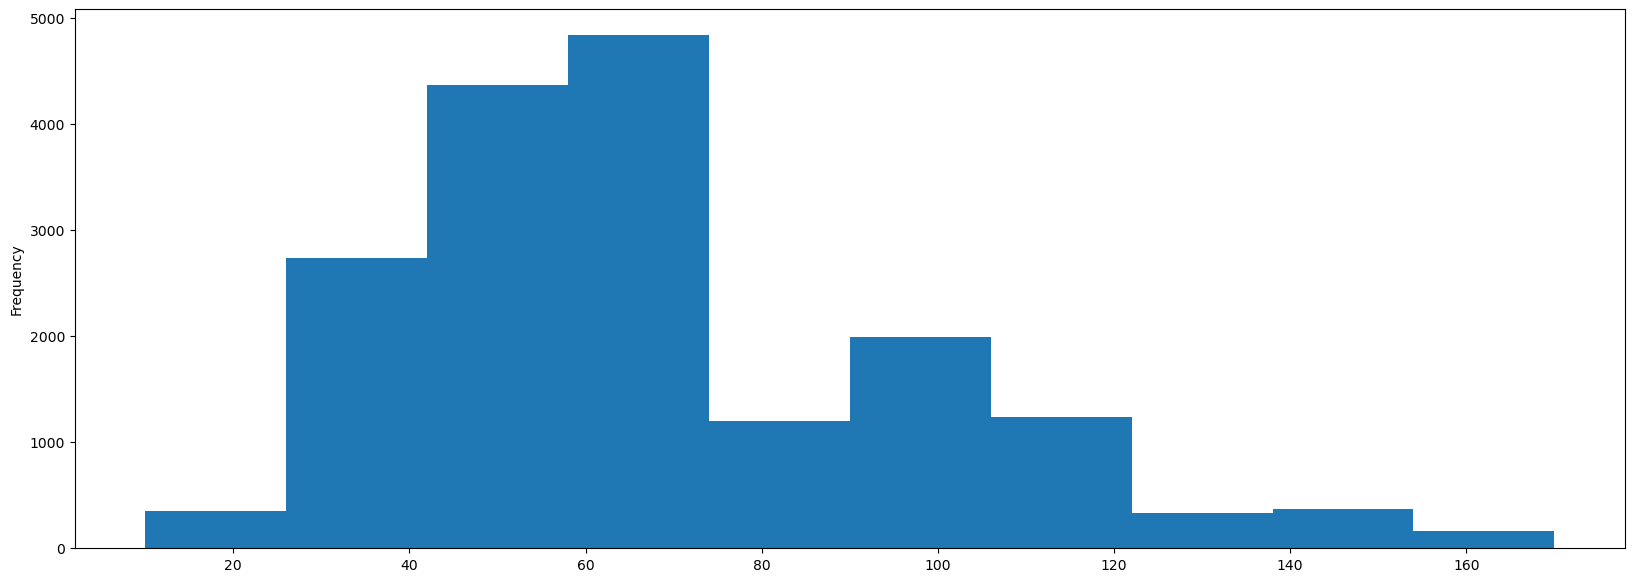

In [27]:
df['Appliances'].plot(kind="hist",figsize=(20, 7))
plt.show()

## 7. Correlation

In [28]:
# Calculate Pearson correlation matrix
corr_matrix = df.select_dtypes(include=[np.number]).corr(method='pearson')
matrix=corr_matrix["Appliances"].sort_values(ascending=False)
print((matrix))

Appliances     1.000000
hours          0.416503
lights         0.291109
T8             0.268293
T2             0.264739
T1             0.248221
T6             0.223875
T_out          0.213651
T4             0.195689
T5             0.191782
T3             0.180061
T7             0.175519
T9             0.154471
Tdewpoint      0.081550
RH_5           0.072040
Windspeed      0.055363
RH_1           0.045596
days_num       0.044500
seconds       -0.008731
Visibility    -0.024974
RH_4          -0.036932
RH_3          -0.088410
Press_mm_hg   -0.089829
RH_2          -0.109746
RH_7          -0.128740
RH_9          -0.201968
RH_8          -0.218639
RH_6          -0.240142
RH_out        -0.252696
Name: Appliances, dtype: float64


In [29]:
df.head()

date  Appliances     T1       RH_1    T2       RH_2     T3  \
0  2016-01-11 17:00:00          60  19.89  47.596667  19.2  44.790000  19.79   
1  2016-01-11 17:10:00          60  19.89  46.693333  19.2  44.722500  19.79   
2  2016-01-11 17:20:00          50  19.89  46.300000  19.2  44.626667  19.79   
3  2016-01-11 17:30:00          50  19.89  46.066667  19.2  44.590000  19.79   
4  2016-01-11 17:40:00          60  19.89  46.333333  19.2  44.530000  19.79   

        RH_3         T4       RH_4  ...  Windspeed  Visibility  Press_mm_hg  \
0  44.730000  19.000000  45.566667  ...   7.000000   63.000000        733.5   
1  44.790000  19.000000  45.992500  ...   6.666667   59.166667        733.6   
2  44.933333  18.926667  45.890000  ...   6.333333   55.333333        733.7   
3  45.000000  18.890000  45.723333  ...   6.000000   51.500000        733.8   
4  45.000000  18.890000  45.530000  ...   5.666667   47.666667        733.9   

   Tdewpoint  lights  exact_date  hours  seconds    days  days_num  
0        5.3      30  2016-01-11     17        0  Monday         0  
1        5.2      30  2016-01-11     17      600  Monday         0  
2        5.1      30  2016-01-11     17     1200  Monday         0  
3        5.0      40  2016-01-11     17     1800  Monday         0  
4        4.9      40  2016-01-11     17     2400  Monday         0  

[5 rows x 32 columns]

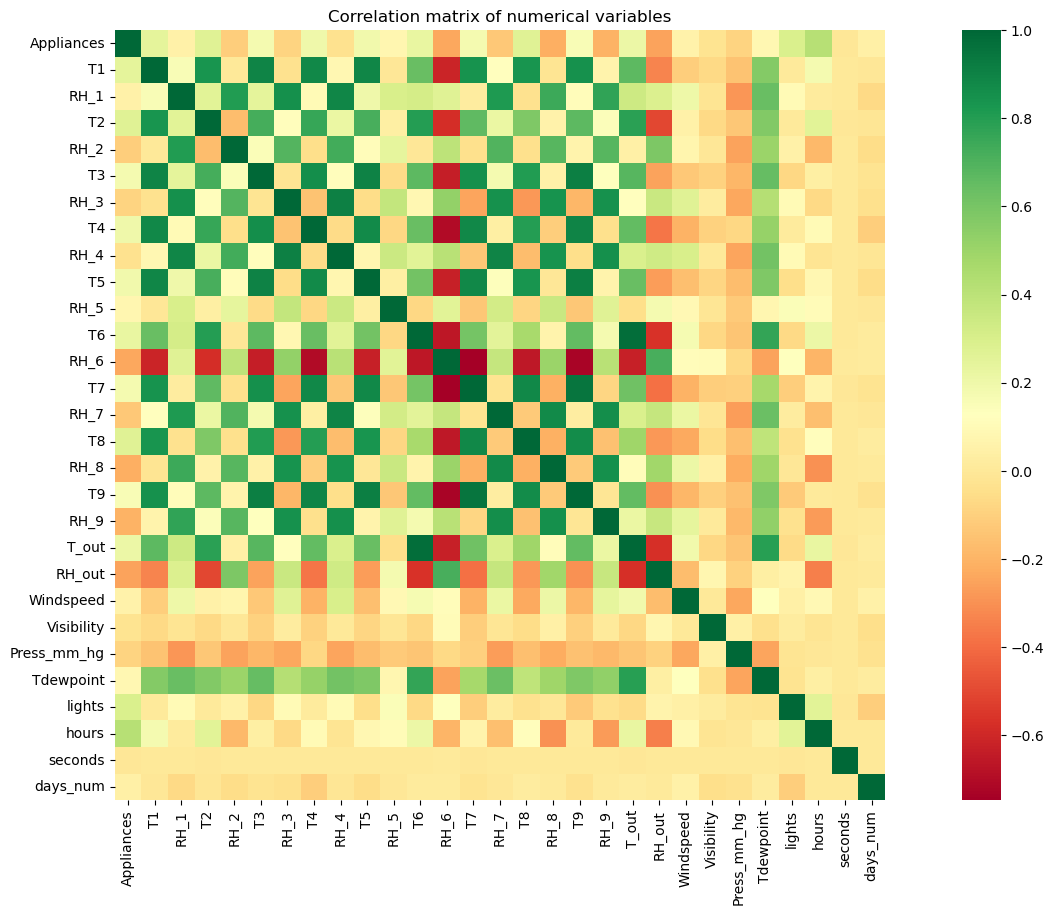

In [30]:
plt.figure(figsize=(20,10))
title = 'Correlation matrix of numerical variables'
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), square=True, cmap='RdYlGn')
plt.title(title)
plt.ioff()

## 8. Split dataset into Train and Test

In [31]:
# Split the dataset
x= df[['lights','T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6','RH_6', 'T7', 'RH_7','T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'RH_out', 'Windspeed', 'Visibility', 
       'hours', 'days_num','Tdewpoint','Press_mm_hg']]
X=x.values
y = df['Appliances'].values

In [32]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [41]:
y_train

array([50, 50, 50, ..., 60, 40, 60], dtype=int64)

## 9. Modeling

In [42]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R^2 scores
    train_r2 = r2_score(y_train, y_train_pred)*100
    test_r2 = r2_score(y_test, y_test_pred)*100
    
    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Print the scores
    print(f"Training Score (R^2): {train_r2}")
    print(f"Testing Score (R^2): {test_r2}")
    print(f"Training RMSE: {train_rmse}")
    print(f"Testing RMSE: {test_rmse}")

# Example usage remains the same
# evaluate_model(linear_model, X_train, y_train, X_test, y_test)
# evaluate_model(random_forest, X_train, y_train, X_test, y_test)
# evaluate_model(svm_model, X_train, y_train, X_test, y_test)


### 9.1 DecisionTreeRegressor

In [55]:
# Define the parameters to test
max_depths = [30, 50, 70, 90]
min_samples_leafs = [2, 5, 10]

# Initialize an empty list to store results
test_results = []

# Iterate over each combination of max_depth and min_samples_leaf
for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        # Initialize Decision Tree Regressor with current parameters
        dt = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        
        # Train the model
        dt.fit(X_train, y_train)
        
        # Predict on testing data
        y_test_pred = dt.predict(X_test)
        
        # Calculate R^2 score
        test_r2 = r2_score(y_test, y_test_pred)
        
        # Append results
        test_results.append((max_depth, min_samples_leaf, test_r2))

# Find the best parameters based on highest test R^2 score
best_params = max(test_results, key=lambda x: x[2])
best_max_depth = best_params[0]
best_min_samples_leaf = best_params[1]

# Initialize Decision Tree Regressor with best parameters
best_dt_model = DecisionTreeRegressor(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)

print("Decision Tree:")
evaluate_model(best_dt_model, X_train, y_train, X_test, y_test)

Decision Tree:
Training Score (R^2): 86.82198196473298
Testing Score (R^2): 57.59428216178924
Training RMSE: 10.295516244589663
Testing RMSE: 18.851387483538744


### 9.2 Random Forest

In [73]:
# Define lists of hyperparameters to test
n_estimators = [100, 200, 500]
max_depths = [ 50, 70]
min_samples_leafs = [2, 5]

# Initialize an empty list to store results
test_results = []

# Iterate over each combination of hyperparameters
for estimator in n_estimators:
    for max_depth in max_depths:
        for min_samples_leaf in min_samples_leafs: 
            # Initialize RandomForestRegressor with current hyperparameters
            rf = RandomForestRegressor(n_estimators=estimator, max_depth=max_depth, min_samples_leaf=min_samples_leaf, n_jobs=-1, random_state=42)
            
            # Fit the model on training data
            rf.fit(X_train, y_train)
            
            # Predict on testing data
            y_test_pred  = rf.predict(X_test)
            
            # Calculate R2 score
            r2 = r2_score(y_test, y_test_pred )
            
            # Append results to the list
            test_results.append({'Number of Estimators': estimator, 'Max Depth': max_depth, 'Min Samples Leaf': min_samples_leaf, 'R2 Score': r2})
            
# Find the best hyperparameters based on highest test R2 score
best_params = max(test_results, key=lambda x: x['R2 Score'])
best_n_estimators = best_params['Number of Estimators']
best_max_depth = best_params['Max Depth']
best_min_samples_leaf = best_params['Min Samples Leaf']

# Initialize RandomForestRegressor with best hyperparameters
best_rf_model = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, n_jobs=-1, random_state=42)

print("Random Forest:")
evaluate_model(best_rf_model, X_train, y_train, X_test, y_test)

Random Forest:
Training Score (R^2): 93.20788932252249
Testing Score (R^2): 69.01968914817873
Training RMSE: 7.391378740283236
Testing RMSE: 16.11291055186506


### 9.3 K-Nearest Neighbors (KNN)

In [56]:
# Define the parameters to test
n_neighbors_list = [3, 5, 7, 9]

# Initialize an empty list to store results
test_results = []

# Iterate over each number of neighbors
for n_neighbors in n_neighbors_list:
    # Initialize KNN Regressor with current number of neighbors
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    
    # Train the model
    knn.fit(X_train, y_train)
    
    # Predict on testing data
    y_test_pred = knn.predict(X_test)
    
    # Calculate R^2 score
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append results
    test_results.append((n_neighbors, test_r2))

# Find the best number of neighbors based on highest test R^2 score
best_params = max(test_results, key=lambda x: x[1])
best_n_neighbors = best_params[0]

# Initialize KNN Regressor with best number of neighbors
best_knn_model = KNeighborsRegressor(n_neighbors=best_n_neighbors)

print("K-Nearest Neighbors:")
evaluate_model(best_knn_model, X_train, y_train, X_test, y_test)


K-Nearest Neighbors:
Training Score (R^2): 83.1851524762511
Testing Score (R^2): 60.20294996741524
Training RMSE: 11.629727698000131
Testing RMSE: 18.262345347072966


### 9.4 XGBoost Regressor

In [43]:
# Initialize XGB Regressor
xgb_model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=500,
                    learning_rate=0.1, max_depth=10, subsample=0.9,
                    colsample_bytree=0.9)

# Evaluate the best model
print("XGBoost Regressor:")
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)


XGBoost Regressor:
Training Score (R^2): 99.60583574737068
Testing Score (R^2): 69.26275968424653
Training RMSE: 1.7805808441343698
Testing RMSE: 16.049575383297263


## 10. Accuracy

- Based on the evaluation metrics obtained, the XGBoost Regressor demonstrates superior performance compared to other models considered. It achieved a remarkable training score (R^2) of 99.61%, indicating a high degree of fit to the training data. Furthermore, on the testing set, the XGBoost Regressor maintained a strong R^2 score of 69.26%.
+ Given these compelling results, we have selected the XGBoost Regressor as our model of choice for further accuracy validation and deployment in our machine learning

In [44]:
# Use the XGB Regressor's predict method on the test data
predictions = xgb_model.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 83.07 %.


## 11. Feature Importance

In [45]:
x

lights         T1       RH_1         T2       RH_2         T3  \
0          30  19.890000  47.596667  19.200000  44.790000  19.790000   
1          30  19.890000  46.693333  19.200000  44.722500  19.790000   
2          30  19.890000  46.300000  19.200000  44.626667  19.790000   
3          40  19.890000  46.066667  19.200000  44.590000  19.790000   
4          40  19.890000  46.333333  19.200000  44.530000  19.790000   
...       ...        ...        ...        ...        ...        ...   
19727       0  25.500000  47.456667  26.000000  42.320000  27.663333   
19728       0  25.600000  47.193333  25.968571  42.528571  27.390000   
19729       0  25.533333  46.860000  25.978000  42.534000  27.323333   
19730       0  25.566667  46.560000  25.890000  42.025714  27.200000   
19731       0  25.500000  46.500000  25.754000  42.080000  27.133333   

            RH_3         T4       RH_4         T5  ...         T9       RH_9  \
0      44.730000  19.000000  45.566667  17.166667  ...  17.033333  45.530000   
1      44.790000  19.000000  45.992500  17.166667  ...  17.066667  45.560000   
2      44.933333  18.926667  45.890000  17.166667  ...  17.000000  45.500000   
3      45.000000  18.890000  45.723333  17.166667  ...  17.000000  45.400000   
4      45.000000  18.890000  45.530000  17.200000  ...  17.000000  45.400000   
...          ...        ...        ...        ...  ...        ...        ...   
19727  40.693333  24.700000  45.560000  23.200000  ...  23.200000  46.718000   
19728  41.030000  24.700000  45.626667  23.200000  ...  23.200000  46.751429   
19729  41.090000  24.700000  45.626667  23.200000  ...  23.200000  46.745000   
19730  41.163333  24.700000  45.590000  23.200000  ...  23.200000  46.790000   
19731  41.223333  24.700000  45.590000  23.230000  ...  23.200000  46.790000   

           T_out     RH_out  Windspeed  Visibility  hours  days_num  \
0       6.600000  92.000000   7.000000   63.000000     17         0   
1       6.483333  92.000000   6.666667   59.166667     17         0   
2       6.366667  92.000000   6.333333   55.333333     17         0   
3       6.250000  92.000000   6.000000   51.500000     17         0   
4       6.133333  92.000000   5.666667   47.666667     17         0   
...          ...        ...        ...         ...    ...       ...   
19727  22.966667  55.000000   2.833333   22.166667     16         4   
19728  23.000000  55.000000   3.000000   22.000000     17         4   
19729  22.866667  55.333333   3.166667   22.833333     17         4   
19730  22.733333  55.666667   3.333333   23.666667     17         4   
19731  22.600000  56.000000   3.500000   24.500000     17         4   

       Tdewpoint  Press_mm_hg  
0       5.300000       733.50  
1       5.200000       733.60  
2       5.100000       733.70  
3       5.000000       733.80  
4       4.900000       733.90  
...          ...          ...  
19727  13.366667       755.25  
19728  13.400000       755.20  
19729  13.366667       755.20  
19730  13.333333       755.20  
19731  13.300000       755.20  

[17597 rows x 27 columns]

In [46]:
# Get feature importances
importance_df = pd.DataFrame({
    'feature': x.columns, # feature names
    'importance': xgb_model.feature_importances_ # feature importances
}).sort_values('importance', ascending=False) # Sort feature importances in descending order


In [68]:
importance_df.head(10)

feature  importance
23        hours    0.412122
24     days_num    0.111196
17           T9    0.056282
15           T8    0.052409
26  Press_mm_hg    0.028748
13           T7    0.026672
0        lights    0.021983
9            T5    0.020421
18         RH_9    0.020337
7            T4    0.020123

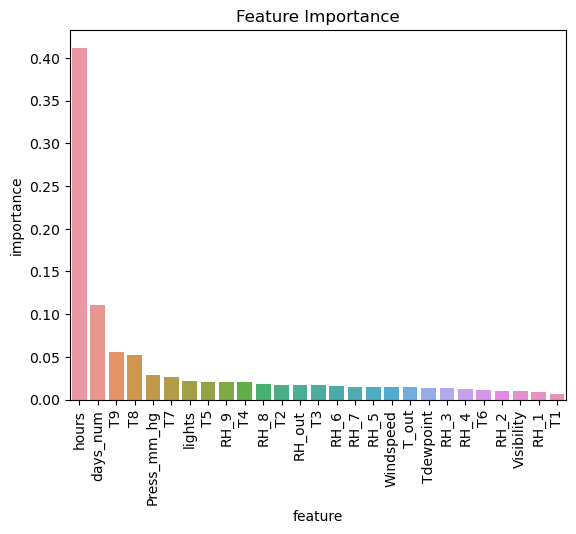

In [78]:
# Plot feature importance graph
#plt.figure(figsize=(40,10))
plt.title("Feature Importance")
sns.barplot(importance_df.head(27), x='feature', y='importance');
plt.xticks(rotation = 90)
plt.show()

## 12. ACTUAL VS PREDICTED

In [79]:
# For XGB Regressor
y_test_pred  = xgb_model.predict(X_test)

pred_df= pd.DataFrame({'Actual': np.round(y_test, 0), 
                   'Predicted': np.round(y_test_pred, 0)})
pred_df[pred_df.Actual == pred_df.Predicted]

Actual  Predicted
11        80       80.0
49        50       50.0
88        50       50.0
93        50       50.0
127       70       70.0
...      ...        ...
3480      60       60.0
3484      50       50.0
3494      60       60.0
3496      60       60.0
3518      80       80.0

[153 rows x 2 columns]

In [80]:
pred_df

Actual  Predicted
0         20       37.0
1        100       92.0
2         50       53.0
3         70       58.0
4         60       78.0
...      ...        ...
3515      50       62.0
3516     110      102.0
3517      50       38.0
3518      80       80.0
3519      40       51.0

[3520 rows x 2 columns]

## 13. Conclusion


- **Decision Tree Regressor**
  - **Training R² Score**: 100%
  - **Testing R² Score**: 42.76%
  
---

- **Random Forest Regressor**
  - **Training R² Score**: 99.68%
  - **Testing R² Score**: 61.52%
  
---

- **K-Nearest Neighbors (KNN) Regressor**
  - **Training R² Score**: 70.56%
  - **Testing R² Score**: 45.97%
  
---

- **XGBoost Regressor**
  - **Training R² Score**: 99.61%
  - **Testing R² Score**: 69.26%
  - **Accuracy**: 89.76%

---

### Best Model for Prediction

- The **XGBoost Regressor** demonstrates the best performance among all the models, with a high **training R² score of 99.61%** and a strong **testing R² score of 69.26%**. It is the most suitable model for predicting the energy consumption of appliances in this dataset.


In [83]:
pred_df.to_csv('XGB-Prediction.csv', index=None)

In [84]:
from IPython.display import FileLink
FileLink('XGB-Prediction.csv')

C:\Users\HP\XGB-Prediction.csv